In [ ]:
#   МОЙ КОД 

import numpy as np 
import pandas as pd 

# импортируем необходимые пакеты
import pandas as pd                 # для работы с табличными данными
import matplotlib.pyplot as plt     # для визуализации
import seaborn as sns               # для визуализации


import nltk   # библиотека для обработки естественного языка
from nltk.corpus import stopwords, wordnet
# stopwords - список стоп-слов (часто встречающиеся слова, которые обычно удаляются: "the", "a", "is", "in")
# wordnet - лексическая база данных английского языка для синонимов и семантических отношени
from nltk.tokenize import word_tokenize
# Функция для разделения текста на отдельные слова (токены)

from nltk.stem import WordNetLemmatizer
# Лемматизатор для приведения слов к их базовой форме (лемме):


import string
import re                           # библиотека обработки регулярных выражений

from sklearn.model_selection import train_test_split         # инструмент сплитования набора данных
from sklearn.feature_extraction.text import TfidfVectorizer  # векторизация текста

from sklearn.linear_model import LogisticRegression          # алгоритм логистической регрессии
from sklearn.metrics import classification_report, ConfusionMatrixDisplay # набор метрик для задач классификации

from catboost import Pool, CatBoostClassifier               # библиотека градиентного спуска

import warnings
warnings.filterwarnings('ignore') # Игнорирование всех предупреждений

In [2]:
# import nltk
# nltk.download('popular')  # скачивает все популярные пакеты

In [3]:
# загружаем тренировочный набор данных
train_data = pd.read_csv(r'D:/Git/recurrent_networks/train.csv')
train_data.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
# загружаем тестовый набор данных
test_data = pd.read_csv(r'D:/Git/recurrent_networks/test.csv')
test_data.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [5]:
#Все ли фильмы содержат категорию-жанр и текстовое описание или имеются пропуски.
print("Пропуски в train_data:")
print(train_data.isnull().sum())

print("\nПропуски в test_data:")
print(test_data.isnull().sum())

Пропуски в train_data:
name     0
genre    0
text     0
dtype: int64

Пропуски в test_data:
name    0
text    0
dtype: int64


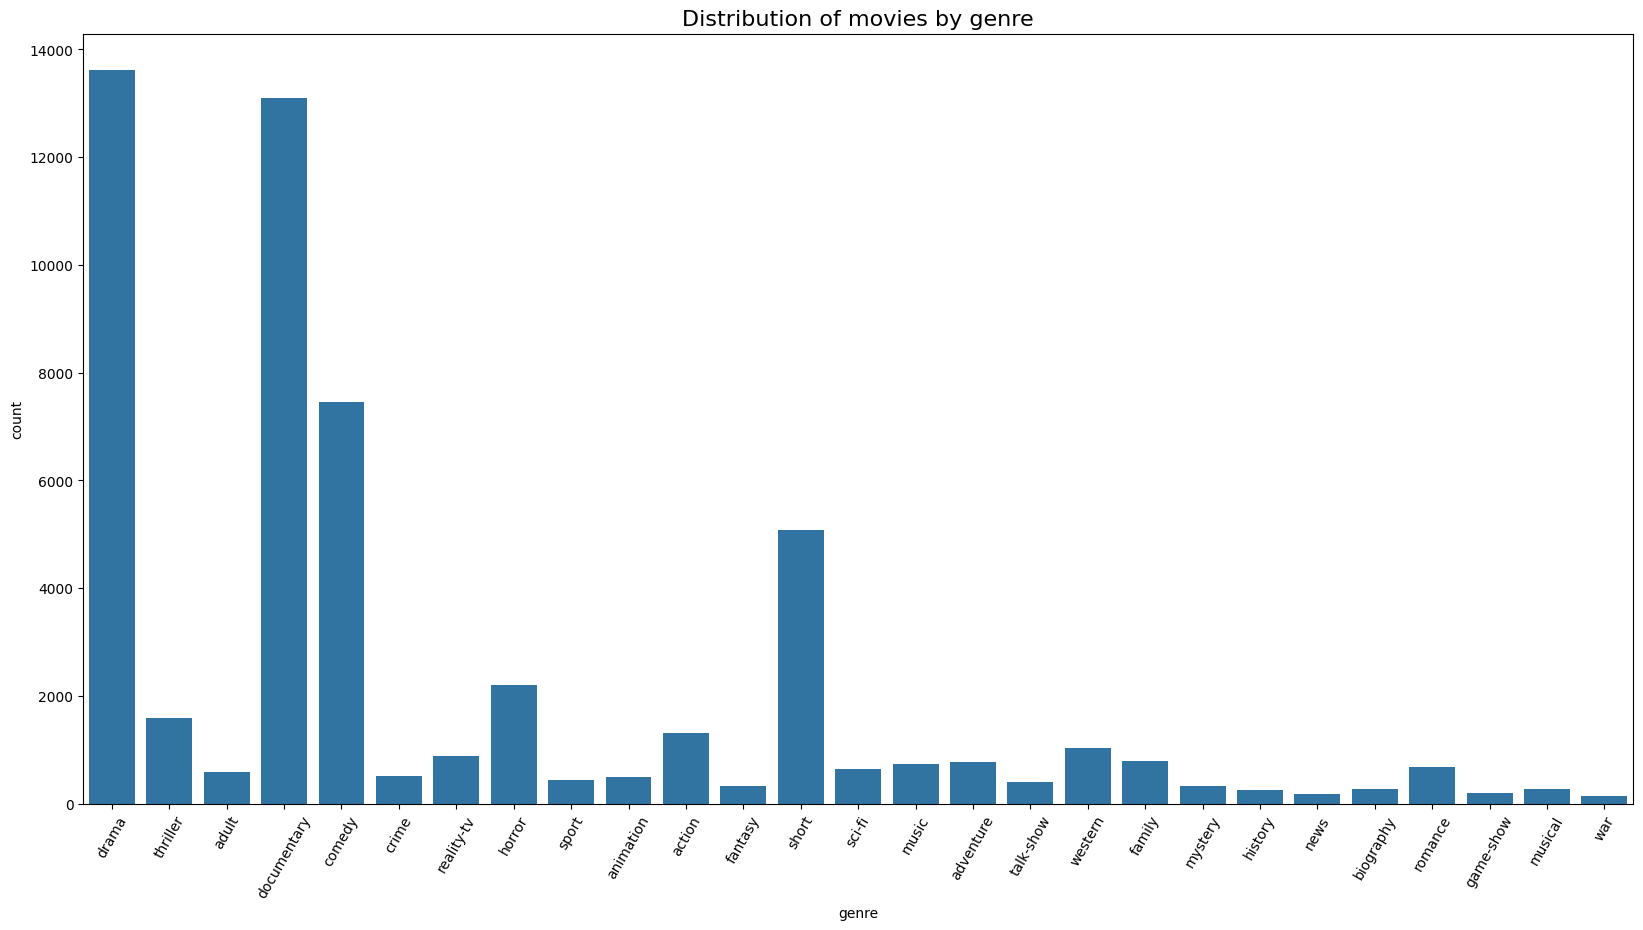

In [6]:
plt.figure(figsize=(20,10))
sns.countplot(train_data, x='genre')   # график для подсчета категориальных признаков
plt.xticks(rotation=60)# Вращает подписи на оси X на 60 градусов
plt.title('Distribution of movies by genre', fontsize=16);

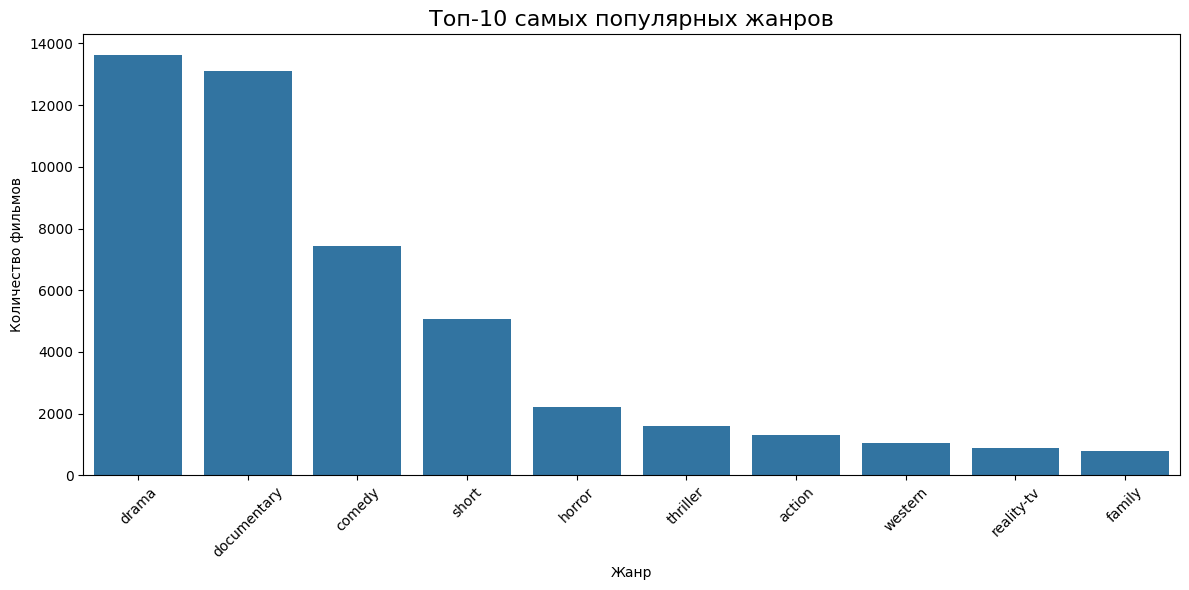

In [7]:
# Топ-10 жанров для наглядности
top_genres = train_data['genre'].value_counts().head(10)

# Создаем гистограмму
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Топ-10 самых популярных жанров', fontsize=16)
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# функция очистки текста
def filtered_text(df, text):
    # удаляем любые числа, оставляя только английские слова, преобразуем к нижнему регистру
    df['clean_text'] = df[text].apply(lambda x: re.sub(r"[^a-z]\w*\d\w*", " ", x.lower().strip()))
    # удаляем любые дополнительные слова в скобках
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"\(.+?\)", "", x).strip())
    # удаляем все знаки препинания
    df['clean_text'] = df['clean_text'].str.translate(str.maketrans(" ", " ", string.punctuation))
    
    # рабиваем текст на отдельные слова-токены
    df['clean_text'] = df['clean_text'].apply(lambda x:word_tokenize(x))
    # леммантизация слов (процесс приведения слова к его базовой (словарной) форме)
    lemmatizer = WordNetLemmatizer()
    df['clean_text'] = df['clean_text'].apply(lambda x: list(map(lambda word: lemmatizer.lemmatize(word), x)))
    # находим и удаляем стоп-слова
    stop_words = set(stopwords.words('english'))
    df['clean_text'] = df['clean_text'].apply(lambda x: list(filter
                                    (lambda word: word not in stop_words and len(word)>2, x)))
    # объединяем токены обратно в текст
    df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x))
    return df

# применим функцию к тренировочному набору 
clean_train = filtered_text(train_data, 'text')
clean_train.head()

,name,genre,text,clean_text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parent yearold o...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empty student field trip museum natural hi...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make end meet edith twi...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers unrecovered body ground zero...


In [9]:
# посмотрим на один пример очищенного текста
clean_train.clean_text[5]

'quality control consists series single take shot filmed summer two day period dry cleaner facility pritchard alabama near mobile quality control exhibit act well condition around labor showcase eversons word fine folk alabama producing superior product similar stylistically form rhythm certain scenario eversons awardwinning critically acclaimed previous film including erie thematic concern several short form work follow daily quotidian task worker rest motion oblique sequel ten year hence eversons creative capital granted project week hole focused employee adjustment material time space personnel quality control consists series single take shot filmed two day period summer dry cleaner facility pritchard alabama near mobile quality control exhibit act well condition around labor similar stylistically form rhythm certain scenario eversons awardwinning critically acclaimed previous film including erie thematic concern several short form work follow daily quotidian task worker rest motion

In [10]:
# применим функцию очистки к тестовой выборке
clean_test = filtered_text(test_data, 'text')
clean_test.head()

,name,text,clean_text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane love life car apartment job especially g...
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherd north tran...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother year serious ...
4,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial art superstar br...


In [11]:
# Посчитаем количество уникальных слов в каждой выборке и общий размер словаря.

words_train = [word for row in clean_train['clean_text'] for word in row.split(' ')]
words_test = [word for row in clean_test['clean_text'] for word in row.split(' ')]
total_voc = set(words_train+words_test)
print('Количество слов в обучающем наборе: %s' % (len(set(words_train))),
     'Количество слов в тестовом наборе: %s' % (len(set(words_test))),
     'Общее количество уникальных слов: %s' % (len(total_voc)), sep='\n')

Количество слов в обучающем наборе: 130939
Количество слов в тестовом наборе: 130683
Общее количество уникальных слов: 200726


In [12]:
# Создаст вектор ДЛЯ КАЖДОГО УНИКАЛЬНОГО СЛОВА во всех текстах
# Возьмет только 50,000 САМЫХ ЧАСТЫХ слов
vectorizer = TfidfVectorizer(max_features=50000)


#  объединяет два столбца вертикально
vectorizer.fit(pd.concat([clean_train.clean_text, clean_test.clean_text], axis=0))
train = vectorizer.transform(clean_train.clean_text)
test = vectorizer.transform(clean_test.clean_text)
print('Размер выборок тренировочной и тестовой: ', train.shape, test.shape, sep='\n')

Размер выборок тренировочной и тестовой: 
(54214, 50000)
(54200, 50000)


In [13]:
# Целевую переменную закодируем порядковым номером для классификации с помощью логистической регрессии.
# Разделим тренировочный набор на обучающую и валидационную выборки.

# создаем список жанров .unique() возвращает массив уникальных значений из столбца
genres = list(clean_train['genre'].unique())
# создаем словарь, где каждому жанру присваиваем порядкой номер
coding_genres = {value: num for num, value in enumerate(genres)}
display(coding_genres)


# жанр фильма меняем на числовое значение 
y = clean_train['genre'].apply(lambda x: coding_genres[x])



# создадим обучающий и валидационный наборы с учетом стратификации для корректного распределения жанров по выборкам
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.2, 
                                                      random_state=42, stratify=y)     


{'drama': 0,
 'thriller': 1,
 'adult': 2,
 'documentary': 3,
 'comedy': 4,
 'crime': 5,
 'reality-tv': 6,
 'horror': 7,
 'sport': 8,
 'animation': 9,
 'action': 10,
 'fantasy': 11,
 'short': 12,
 'sci-fi': 13,
 'music': 14,
 'adventure': 15,
 'talk-show': 16,
 'western': 17,
 'family': 18,
 'mystery': 19,
 'history': 20,
 'news': 21,
 'biography': 22,
 'romance': 23,
 'game-show': 24,
 'musical': 25,
 'war': 26}

In [14]:
# создаем модель логистической регрессии 
clf = LogisticRegression(C=20, class_weight='balanced', multi_class='multinomial',
                         max_iter=1000, random_state=42)
# обучаем
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,20
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [15]:
# предсказываем
y_pred = clf.predict(X_valid)
# посмотрим значения метрик классификации на валидационной выборке
print(classification_report(y_valid, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.633     0.591     0.611      2723
           1      0.245     0.299     0.270       318
           2      0.526     0.508     0.517       118
           3      0.754     0.733     0.744      2619
           4      0.559     0.591     0.575      1490
           5      0.173     0.178     0.176       101
           6      0.403     0.480     0.438       177
           7      0.615     0.630     0.623       441
           8      0.525     0.605     0.562        86
           9      0.263     0.210     0.233       100
          10      0.368     0.441     0.401       263
          11      0.262     0.169     0.206        65
          12      0.364     0.420     0.390      1015
          13      0.388     0.364     0.376       129
          14      0.562     0.678     0.615       146
          15      0.331     0.271     0.298       155
          16      0.493     0.423     0.455        78
          17      0.804    

In [16]:
# support сколько всего текстов в валидационной выборке принадлежат определенному классу
# precision    Доля правильно предсказанных положительных случаев для определенного класса
# recall  доля правильно предсказанных случаев одной категории среди всех случаев этой же категории
# f1-score = 2 × (precision × recall) / (precision + recall)

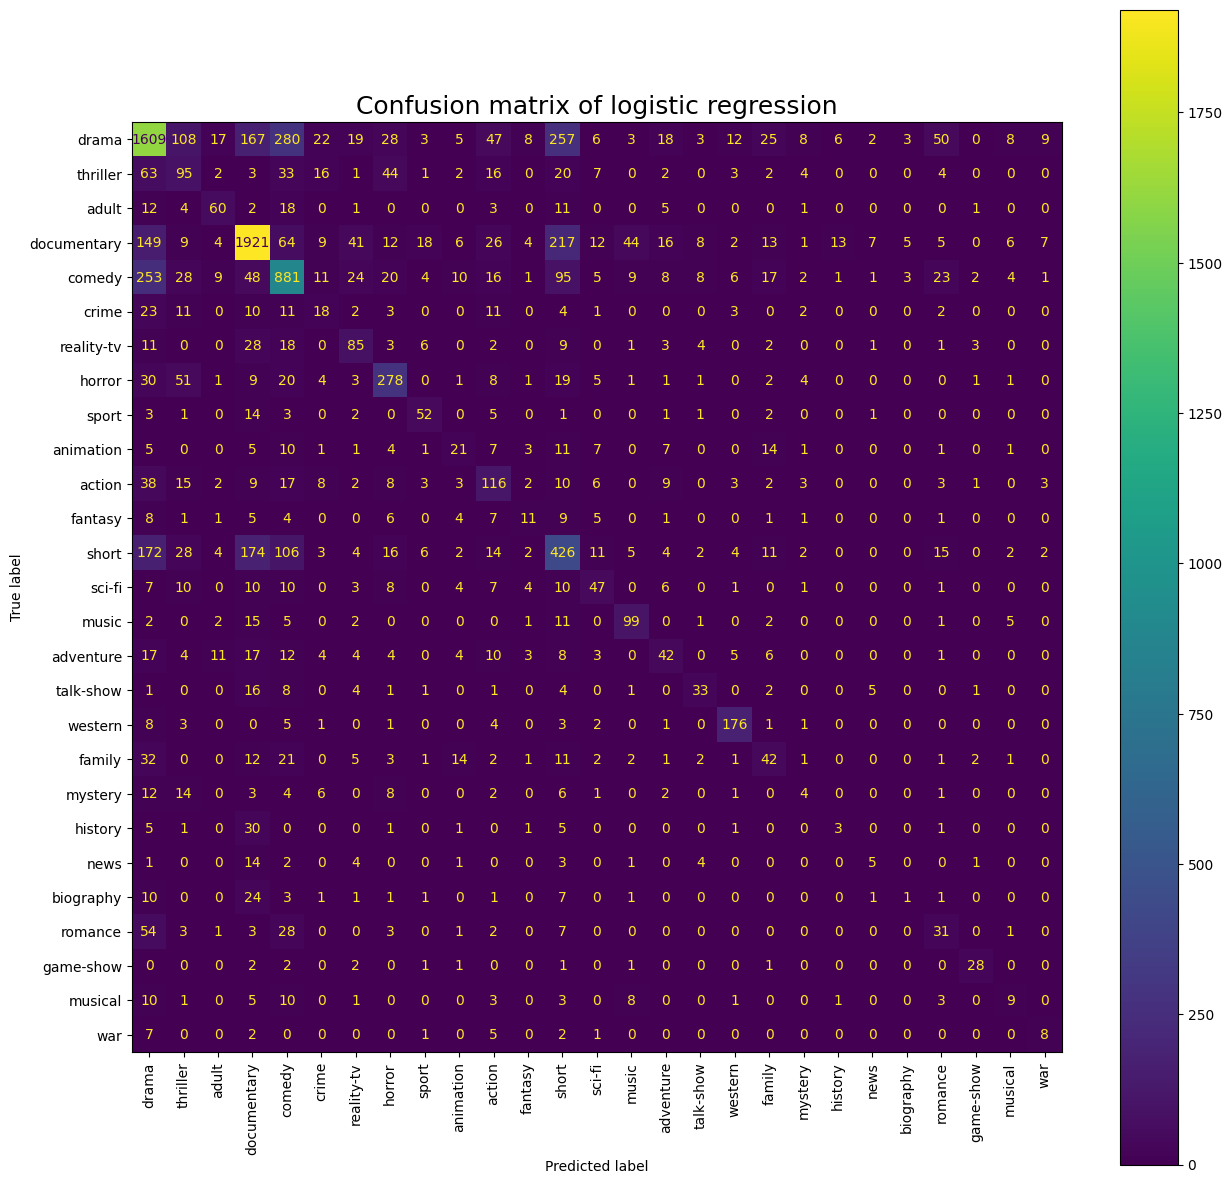

In [17]:
# визуализируем матрицу ошибок
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid, ax=ax);
ax.set_xticklabels(list(coding_genres.keys()), rotation=90)
ax.set_yticklabels(list(coding_genres.keys()))
ax.set_title('Confusion matrix of logistic regression', fontsize=18);